In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

SyntaxError: invalid syntax (506323260.py, line 1)

In [4]:
!pip install -U --user git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to c:\users\91987\appdata\local\temp\pip-req-build-7szhb73m
  Resolved https://github.com/albumentations-team/albumentations to commit 3c510e1422f6663ccd5026950af2d9ea85b5302a
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for scikit-image>=0.16.1 from https://files.pythonhosted.org/packages/3d/97/a09a526eee08683922ca2e37c69742ffdcc879ee40bfe29d3e3d55e821c0/scikit_image-0.22.0-cp39-cp39-win_amd64.whl.metadata
  Using cached scikit_image-0.22.0-cp39-cp39-win_amd64.whl.metadata (13 kB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Obtaining dependency information for opencv-python-headless>=4.0.1 from https://files.pythonhosted.org/packages/e3/10/31b27a7473043eb5317f698ede00e7e129b2de378903bfe0bb4d785a7baf/opencv_python_headless-4.8.1.78-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python_headless-4.8.1.78-cp37-abi3-

  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations 'C:\Users\91987\AppData\Local\Temp\pip-req-build-7szhb73m'
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import sys 
sys.path.append('pytorch/Segmentation/Human-Segmentation-Dataset-master')

In [2]:
import torch 
import cv2 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
import helper

In [68]:
csv_file = 'Human-Segmentation-Dataset-master/train.csv'
Data_dir = ''
device = 'cuda'
epochs = 100
lr = 0.001
image_size = 320
encoder = 'timm-efficientnet-b0'
weights = 'imagenet'
batch_size = 16


In [154]:
df = pd.read_csv(csv_file)
df.head()

masks  \
0  Human-Segmentation-Dataset-master/Ground_Truth...   
1  Human-Segmentation-Dataset-master/Ground_Truth...   
2  Human-Segmentation-Dataset-master/Ground_Truth...   
3  Human-Segmentation-Dataset-master/Ground_Truth...   
4  Human-Segmentation-Dataset-master/Ground_Truth...   

                                              images  
0  Human-Segmentation-Dataset-master/Training_Ima...  
1  Human-Segmentation-Dataset-master/Training_Ima...  
2  Human-Segmentation-Dataset-master/Training_Ima...  
3  Human-Segmentation-Dataset-master/Training_Ima...  
4  Human-Segmentation-Dataset-master/Training_Ima...

In [22]:
row = df.iloc[21]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

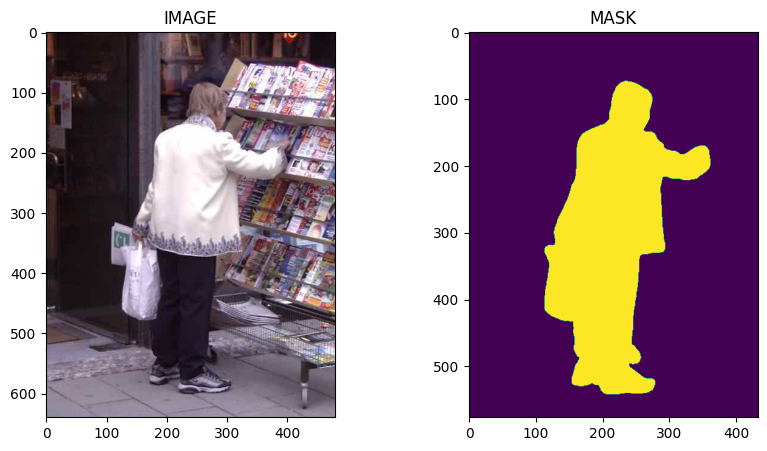

In [23]:
f,(ax1,ax2) = plt.subplots(1,2,figsize = (10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [7]:
train_df,valid_df = train_test_split(df,test_size=0.2,random_state=42)

In [18]:
import albumentations as A


In [37]:
def get_train_augs():
    return A.Compose([
        A.Resize(image_size,image_size),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p=0.5)
    ],is_check_shapes=False)
def get_val_augs():
    return A.Compose([
        A.Resize(image_size,image_size)
    ],is_check_shapes=False)

        

In [38]:
from torch.utils.data import Dataset

In [39]:
class SegmentationDataset(Dataset):
    def __init__(self,df,augmentations):
        self.df = df
        self.augmentations = augmentations
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        
        row = self.df.iloc[idx]
        
        image_path = row.images
        mask_path = row.masks
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask,axis = -1)
        
        if self.augmentations:
            data = self.augmentations(image = image,mask = mask)
            image = data['image']
            mask = data['mask']
            
        image = np.transpose(image,(2,0,1)).astype(np.float32)
        mask = np.transpose(mask,(2,0,1)).astype(np.float32)
        
        image = torch.Tensor(image)/255.0
        mask = torch.round(torch.Tensor(mask)/255.0)
        
        return image,mask
        
            

In [156]:
trainset = SegmentationDataset(train_df,get_train_augs())
# trainset.shape

AttributeError: 'SegmentationDataset' object has no attribute 'shape'

In [41]:
valset = SegmentationDataset(valid_df,get_val_augs())

In [42]:
len(trainset),len(valset)

(232, 58)

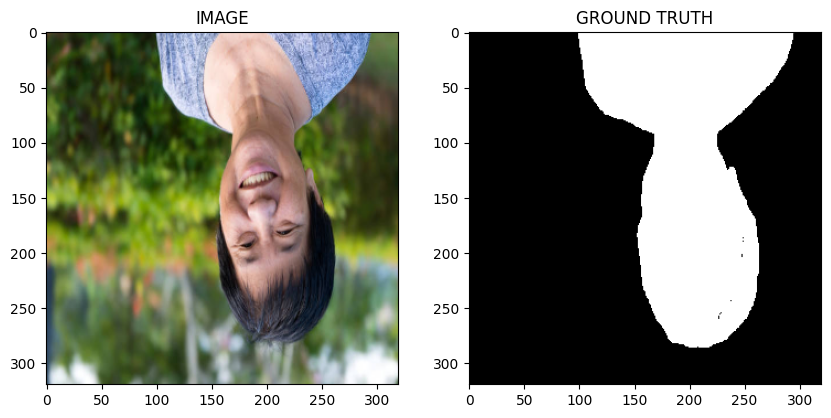

In [47]:
idx = 3
image, mask = trainset[idx]
helper.show_image(image,mask)
# print(image,mask)

In [48]:
from torch.utils.data import DataLoader

In [49]:
trainloader = DataLoader(trainset, batch_size = batch_size,shuffle = True)
validloader = DataLoader(valset,batch_size = batch_size)

In [50]:
len(trainloader)

15

In [51]:
for image,mask in trainloader:
    break
print(image.shape)
print(mask.shape)

torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])


In [61]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

C:\Users\91987\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [62]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()
        self.arc = smp.Unet(
            encoder_name = encoder,
            encoder_weights = weights,
            in_channels = 3,
            classes = 1,
            activation = None
        )
    def forward(self,images,masks = None):
        logits = self.arc(images)
        if masks !=None:
            loss1 = DiceLoss(mode = 'binary')(logits,masks)
            loss2 = nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1+loss2
        return logits

In [69]:
model = SegmentationModel().to('cuda')

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to C:\Users\91987/.cache\torch\hub\checkpoints\tf_efficientnet_b0-0af12548.pth
100%|██████████████████████████████████████████████████████████████████████████████| 20.4M/20.4M [00:24<00:00, 881kB/s]


In [83]:
def training(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    
    for images,masks in tqdm(data_loader):
        images = images.to('cuda')
        masks = masks.to('cuda')
        optimizer.zero_grad()
        logits, loss = model(images,masks)
        loss.backward()
        optimizer.step()
        
        total_loss +=loss.item()
    return total_loss/len(data_loader)

In [89]:
def validation(data_loader, model):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images,masks in tqdm(data_loader):
            images = images.to('cuda')
            masks = masks.to('cuda')

            logits, loss = model(images,masks)
            total_loss +=loss.item()
    return total_loss/len(data_loader)

In [90]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr, weight_decay = 0.001)

In [93]:
best_valid_loss = np.Inf
for i in range(epochs):
    train_loss = training(trainloader,model,optimizer)
    valid_loss = validation(validloader,model)
    
    if valid_loss<best_valid_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print("Saved...")
        best_valid_loss = valid_loss
        
    print(f'Epoch : {i+1} Train_loss : {train_loss} Valid_Loss : {valid_loss}')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.67s/it]


Saved...
Epoch : 1 Train_loss : 0.24801070988178253 Valid_Loss : 0.20025895535945892


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.69s/it]


Epoch : 2 Train_loss : 0.20013748606046042 Valid_Loss : 0.2039434053003788


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.70s/it]


Saved...
Epoch : 3 Train_loss : 0.20301630795001985 Valid_Loss : 0.196671050041914


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.67s/it]


Saved...
Epoch : 4 Train_loss : 0.20167649189631146 Valid_Loss : 0.18168988823890686


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch : 5 Train_loss : 0.20675871074199675 Valid_Loss : 0.2851690575480461


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch : 6 Train_loss : 0.19272346347570418 Valid_Loss : 0.29007016867399216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 7 Train_loss : 0.1846128205458323 Valid_Loss : 0.2393738403916359


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 8 Train_loss : 0.21016031205654145 Valid_Loss : 0.2444647140800953


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 9 Train_loss : 0.14321141292651493 Valid_Loss : 0.20752913504838943


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 10 Train_loss : 0.15743723313013713 Valid_Loss : 0.3526383675634861


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 11 Train_loss : 0.1628338009119034 Valid_Loss : 0.281170129776001


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 12 Train_loss : 0.13623388558626176 Valid_Loss : 0.24623483791947365


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 13 Train_loss : 0.13977568844954172 Valid_Loss : 0.26721617206931114


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 14 Train_loss : 0.14521393279234568 Valid_Loss : 0.24462159723043442


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 15 Train_loss : 0.13435108760992687 Valid_Loss : 0.19919557496905327


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch : 16 Train_loss : 0.13146860202153524 Valid_Loss : 0.23569634556770325


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch : 17 Train_loss : 0.11910011917352677 Valid_Loss : 0.2651343047618866


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 18 Train_loss : 0.12150256832440694 Valid_Loss : 0.37764738872647285


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 19 Train_loss : 0.14486605674028397 Valid_Loss : 0.3260251097381115


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 20 Train_loss : 0.14547837376594544 Valid_Loss : 0.2806031107902527


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 21 Train_loss : 0.1193455696105957 Valid_Loss : 0.22016431763768196


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 22 Train_loss : 0.15007907251516978 Valid_Loss : 0.29082783684134483


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 23 Train_loss : 0.16573796917994818 Valid_Loss : 0.2745743989944458


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 24 Train_loss : 0.1389756018916766 Valid_Loss : 0.3198074474930763


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 25 Train_loss : 0.2111141453186671 Valid_Loss : 0.6211039200425148


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 26 Train_loss : 0.2874793291091919 Valid_Loss : 0.42314574122428894


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 27 Train_loss : 0.20009882748126984 Valid_Loss : 0.34928595274686813


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch : 28 Train_loss : 0.1890743429462115 Valid_Loss : 0.2552872560918331


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 29 Train_loss : 0.15436782389879228 Valid_Loss : 0.26248326897621155


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 30 Train_loss : 0.13952328264713287 Valid_Loss : 0.5471977144479752


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 31 Train_loss : 0.14757510075966518 Valid_Loss : 0.3909868337213993


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 32 Train_loss : 0.1309577316045761 Valid_Loss : 0.3216976225376129


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 33 Train_loss : 0.16663631647825242 Valid_Loss : 0.2774808220565319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 34 Train_loss : 0.18419537196556726 Valid_Loss : 0.36026135832071304


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 35 Train_loss : 0.20674507617950438 Valid_Loss : 0.2968500927090645


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 36 Train_loss : 0.1499076823393504 Valid_Loss : 0.2978077195584774


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 37 Train_loss : 0.12679075797398884 Valid_Loss : 0.2619622088968754


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 38 Train_loss : 0.10857944736878077 Valid_Loss : 0.3087747022509575


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 39 Train_loss : 0.13253333866596223 Valid_Loss : 0.3270210511982441


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 40 Train_loss : 0.11258330593506495 Valid_Loss : 0.24206967279314995


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 41 Train_loss : 0.16239039450883866 Valid_Loss : 0.4121933951973915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 42 Train_loss : 0.16150651425123214 Valid_Loss : 0.26647570356726646


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 43 Train_loss : 0.18137024144331615 Valid_Loss : 0.3724752888083458


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 44 Train_loss : 0.16040944705406826 Valid_Loss : 0.3879128098487854


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 45 Train_loss : 0.1607219452659289 Valid_Loss : 0.43417198210954666


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 46 Train_loss : 0.1302255670229594 Valid_Loss : 0.2294342778623104


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 47 Train_loss : 0.11187293877204259 Valid_Loss : 0.33150842785835266


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 48 Train_loss : 0.11535193274418513 Valid_Loss : 0.2777770347893238


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 49 Train_loss : 0.13800766319036484 Valid_Loss : 0.21241456642746925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 50 Train_loss : 0.1128639022509257 Valid_Loss : 0.23046912252902985


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 51 Train_loss : 0.12201379289229711 Valid_Loss : 0.27265123277902603


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 52 Train_loss : 0.14280488193035126 Valid_Loss : 0.2496281936764717


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 53 Train_loss : 0.14866803934176762 Valid_Loss : 0.3269181363284588


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 54 Train_loss : 0.14524780412515004 Valid_Loss : 0.45130183175206184


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 55 Train_loss : 0.11568027337392171 Valid_Loss : 0.306266937404871


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 56 Train_loss : 0.0993297184507052 Valid_Loss : 0.49187372624874115


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 57 Train_loss : 0.09184358417987823 Valid_Loss : 0.23961512371897697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 58 Train_loss : 0.11251074820756912 Valid_Loss : 0.28716452419757843


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 59 Train_loss : 0.14271390835444134 Valid_Loss : 0.27956444025039673


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 60 Train_loss : 0.1443840483824412 Valid_Loss : 0.30673688650131226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 61 Train_loss : 0.12812754064798354 Valid_Loss : 0.23955700173974037


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 62 Train_loss : 0.12505933443705242 Valid_Loss : 0.3364463560283184


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 63 Train_loss : 0.1322321265935898 Valid_Loss : 0.3449660912156105


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 64 Train_loss : 0.1479615241289139 Valid_Loss : 0.37816450744867325


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 65 Train_loss : 0.11234197616577149 Valid_Loss : 0.2686462886631489


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 66 Train_loss : 0.1567513758937518 Valid_Loss : 0.2938021384179592


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 67 Train_loss : 0.12074066797892252 Valid_Loss : 0.378353763371706


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 68 Train_loss : 0.12519295364618302 Valid_Loss : 0.4197467602789402


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 69 Train_loss : 0.21447341839472453 Valid_Loss : 0.4086868315935135


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 70 Train_loss : 0.22460214346647261 Valid_Loss : 0.23694542050361633


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 71 Train_loss : 0.1665420408050219 Valid_Loss : 0.48632287979125977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 72 Train_loss : 0.1632201666633288 Valid_Loss : 0.39689527079463005


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 73 Train_loss : 0.15743226607640584 Valid_Loss : 0.28262846544384956


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 74 Train_loss : 0.12033714602390926 Valid_Loss : 0.37949416786432266


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 75 Train_loss : 0.14022972186406454 Valid_Loss : 0.21820157766342163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 76 Train_loss : 0.13033069868882496 Valid_Loss : 0.4764896035194397


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 77 Train_loss : 0.12319454203049342 Valid_Loss : 0.3241298384964466


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 78 Train_loss : 0.10093751649061838 Valid_Loss : 0.28431497514247894


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 79 Train_loss : 0.10279144992431005 Valid_Loss : 0.4587017633020878


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 80 Train_loss : 0.10233961840470632 Valid_Loss : 0.27814482152462006


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 81 Train_loss : 0.11912128974994024 Valid_Loss : 0.24295784905552864


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 82 Train_loss : 0.15532395342985789 Valid_Loss : 0.3069929853081703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 83 Train_loss : 0.20094169278939564 Valid_Loss : 0.2750731632113457


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 84 Train_loss : 0.1427559072772662 Valid_Loss : 0.4855652377009392


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 85 Train_loss : 0.1605211208264033 Valid_Loss : 0.36656497046351433


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 86 Train_loss : 0.13907787303129832 Valid_Loss : 0.2683880291879177


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 87 Train_loss : 0.1436078871289889 Valid_Loss : 0.3389081135392189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 88 Train_loss : 0.13652623395125071 Valid_Loss : 0.2850823551416397


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 89 Train_loss : 0.14602221796909967 Valid_Loss : 0.22957344725728035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 90 Train_loss : 0.14321733762820563 Valid_Loss : 0.2980669289827347


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 91 Train_loss : 0.16259992669026058 Valid_Loss : 0.3315705507993698


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 92 Train_loss : 0.15417702198028566 Valid_Loss : 0.3855430707335472


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 93 Train_loss : 0.1382008617122968 Valid_Loss : 0.39626089856028557


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 94 Train_loss : 0.10283014227946599 Valid_Loss : 0.2688129022717476


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 95 Train_loss : 0.11016732901334762 Valid_Loss : 0.3234252966940403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch : 96 Train_loss : 0.11367265035708746 Valid_Loss : 0.3427172116935253


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch : 97 Train_loss : 0.1260940323273341 Valid_Loss : 0.24686077423393726


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 98 Train_loss : 0.1318434034784635 Valid_Loss : 0.2976524159312248


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch : 99 Train_loss : 0.14700518747170765 Valid_Loss : 0.24370161071419716


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]

Epoch : 100 Train_loss : 0.1291807452837626 Valid_Loss : 0.24956326931715012


C:\Users\91987\Documents\python\pytorch\Segmentation\helper.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))


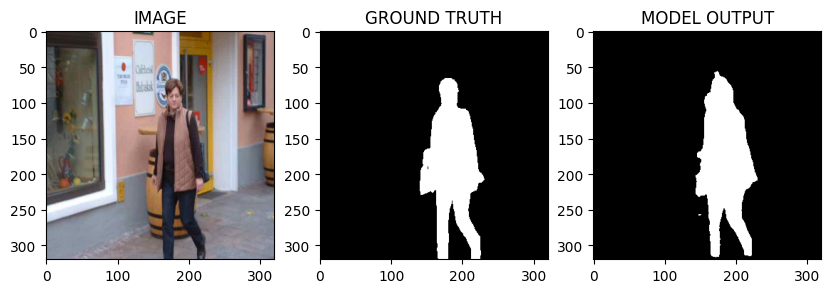

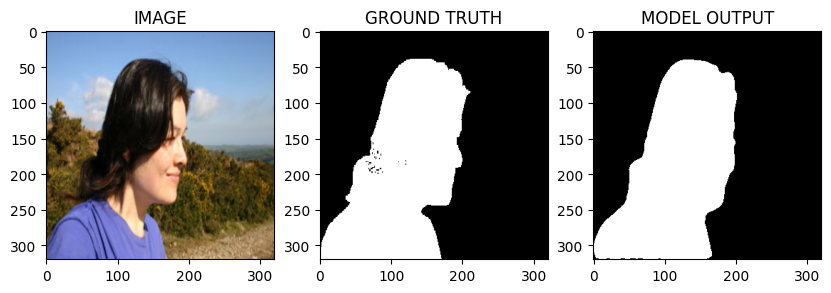

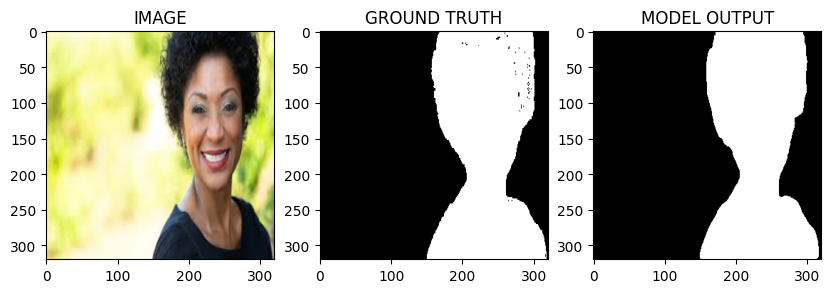

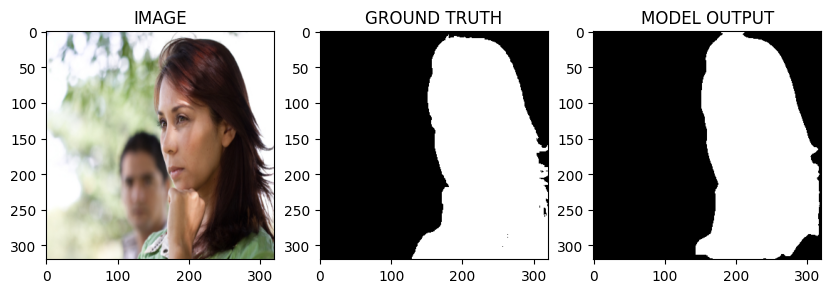

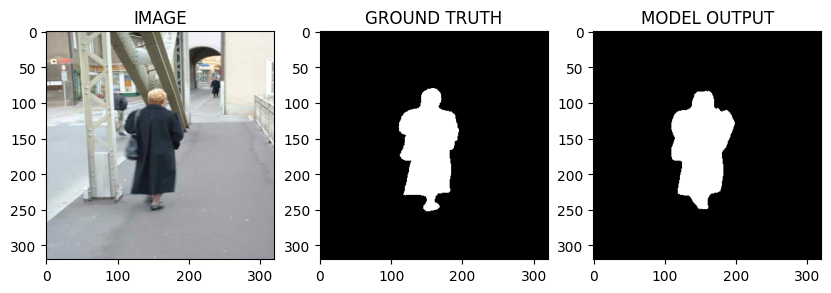

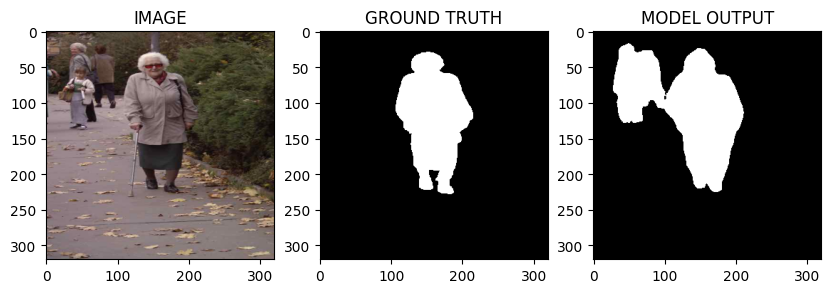

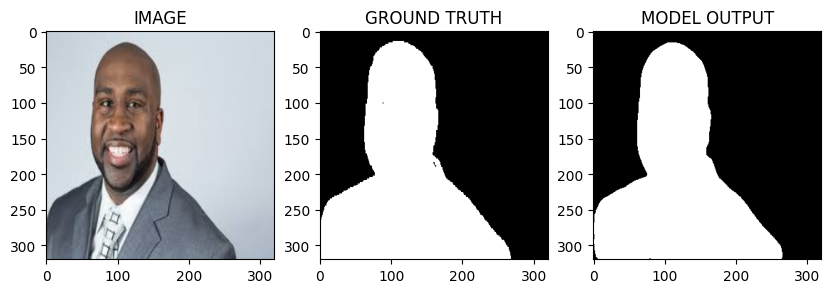

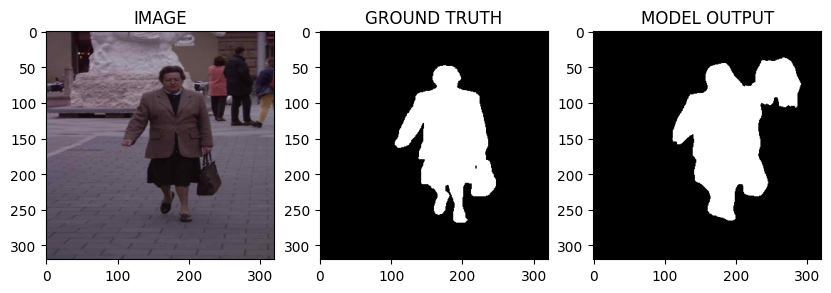

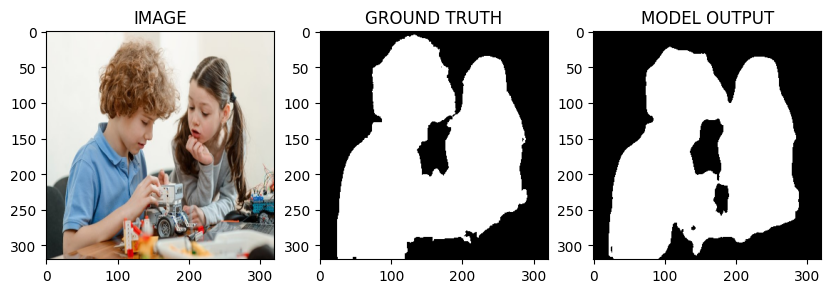

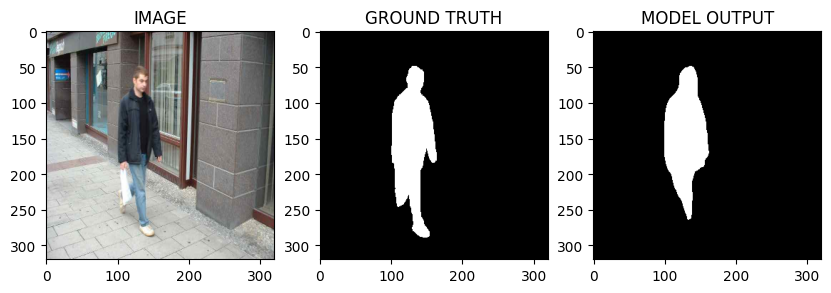

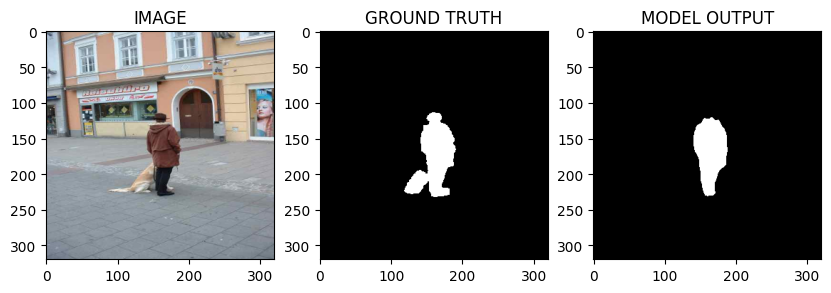

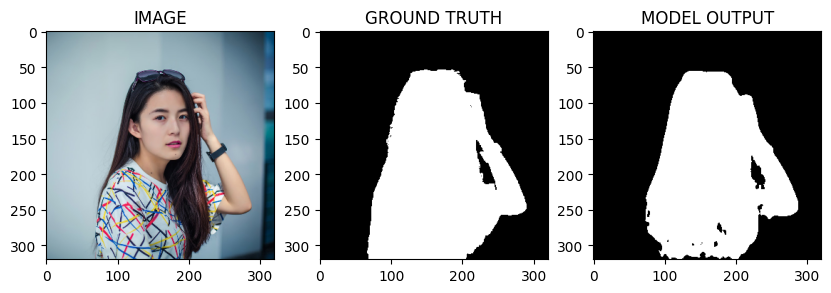

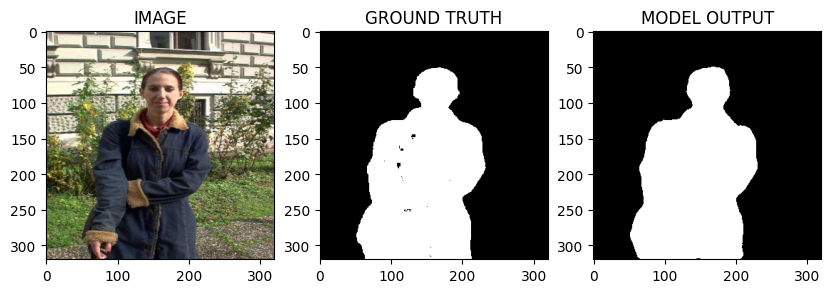

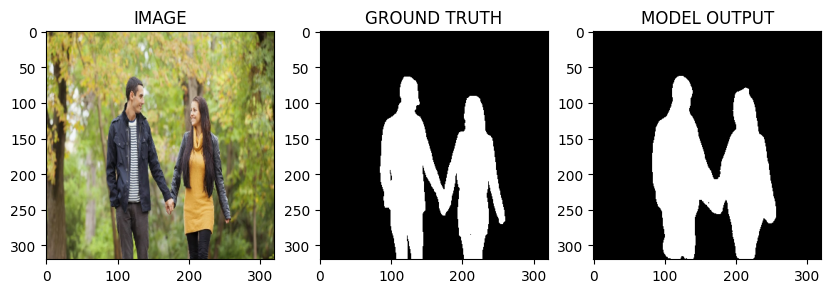

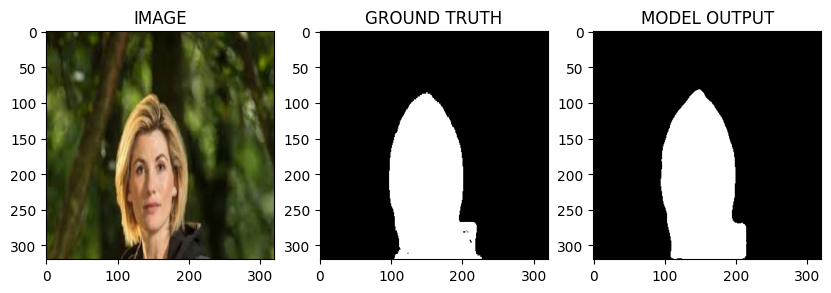

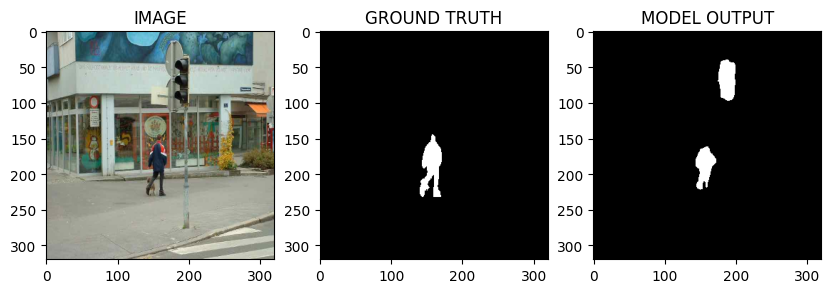

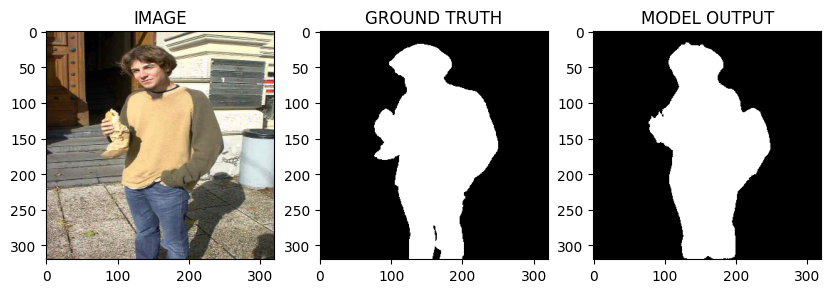

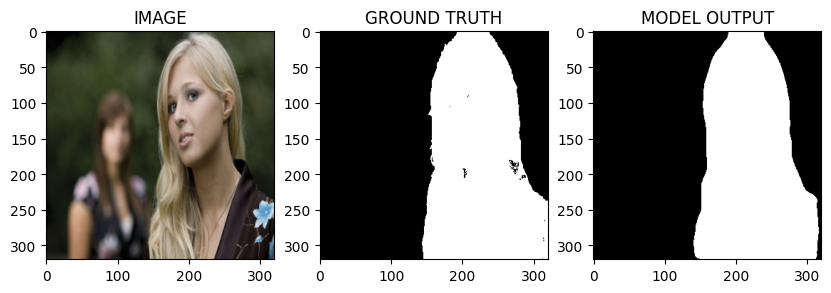

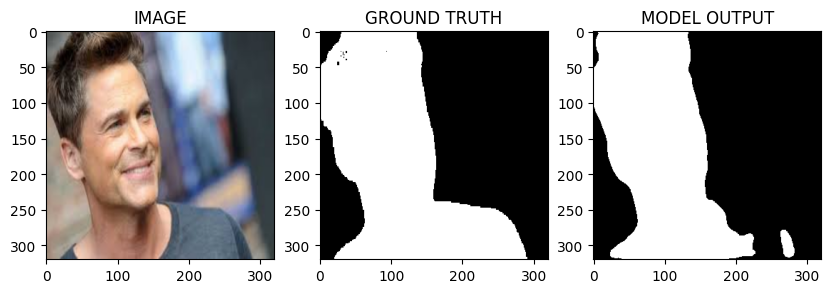

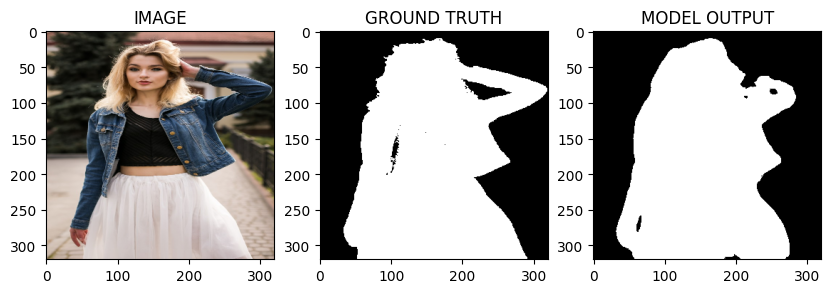

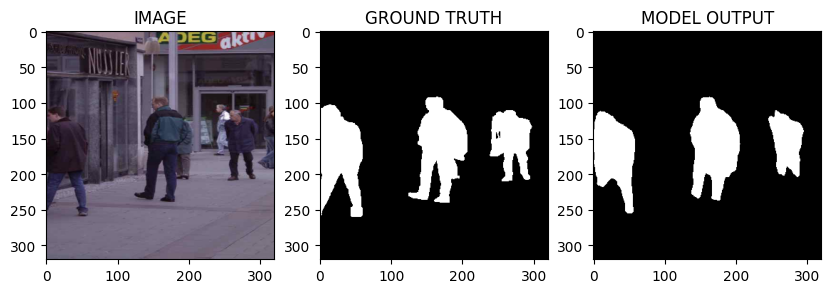

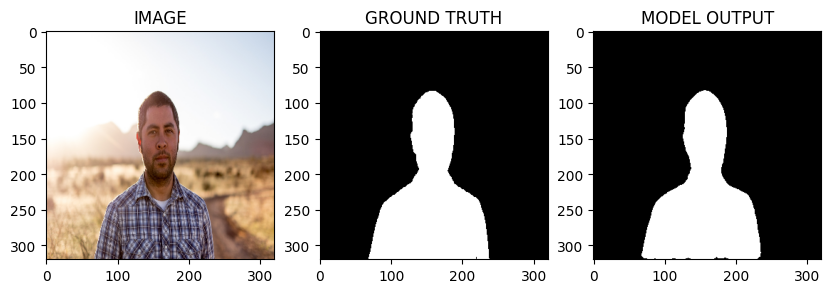

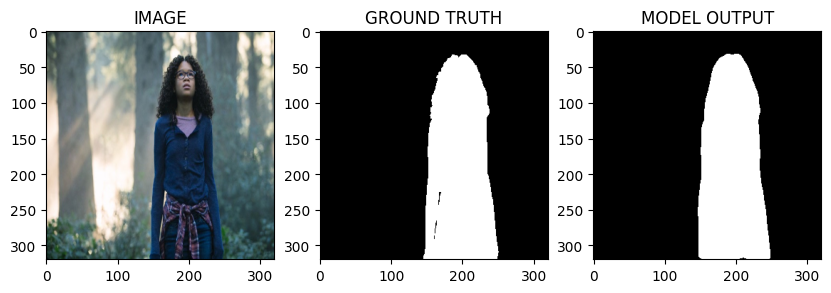

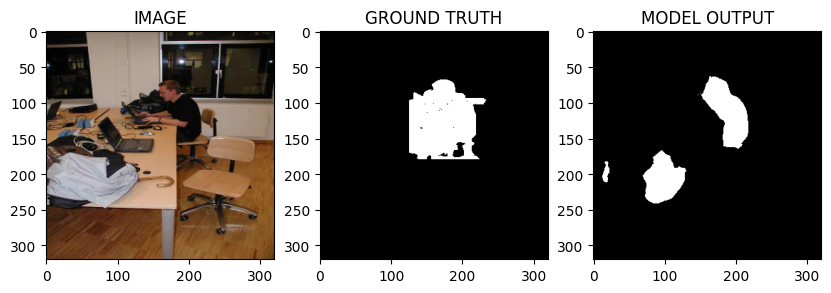

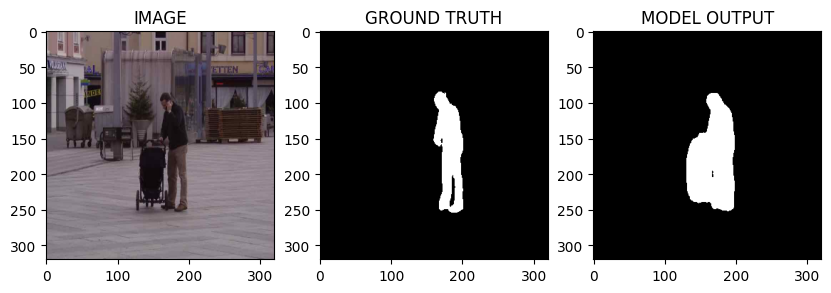

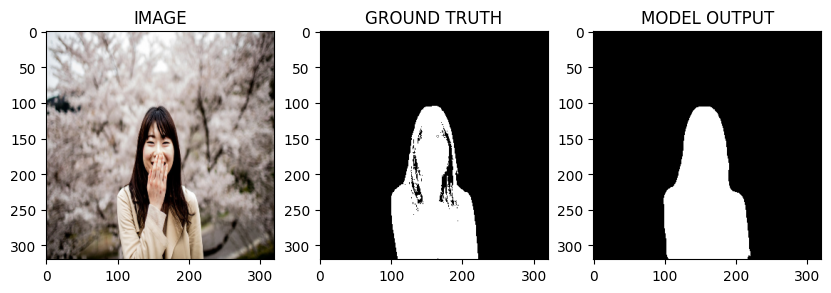

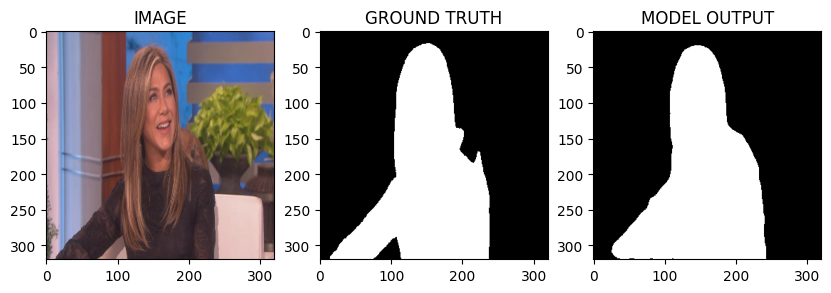

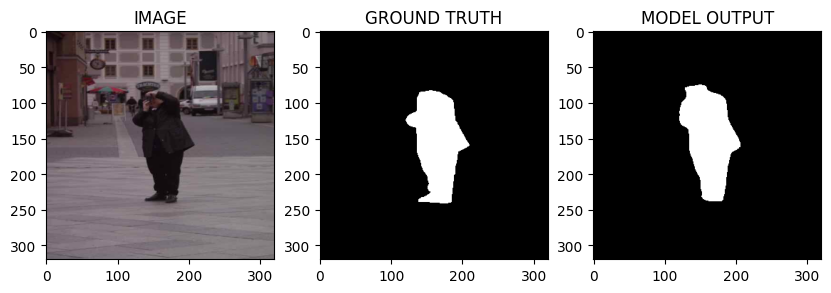

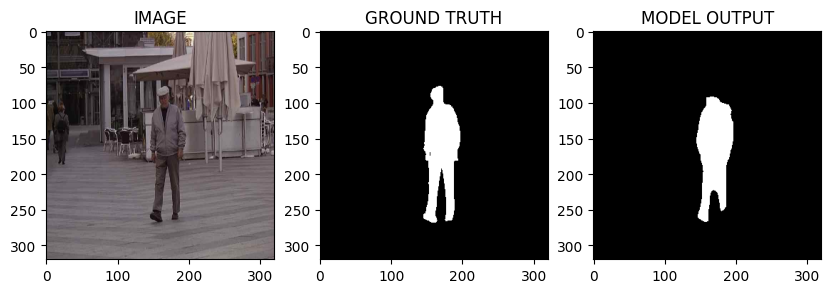

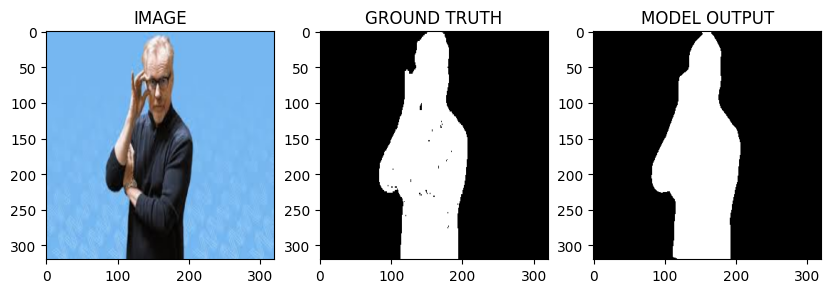

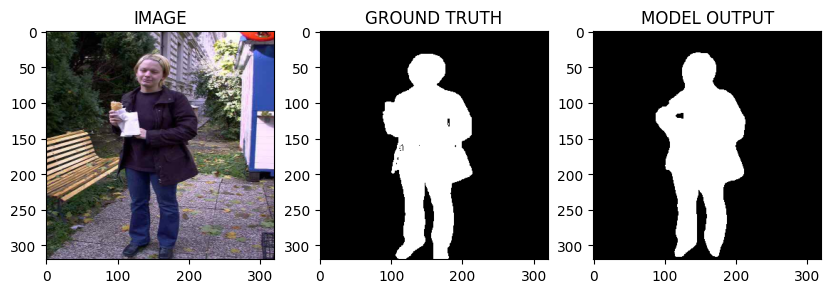

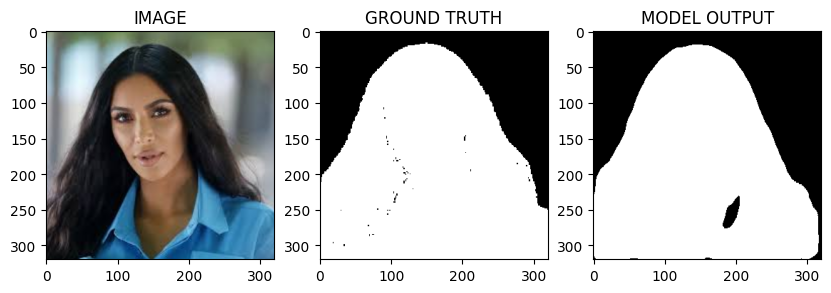

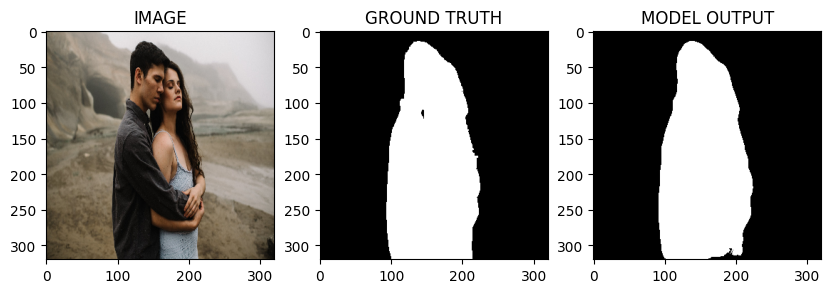

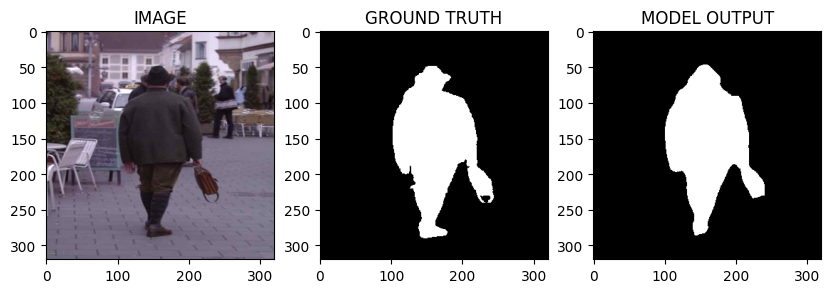

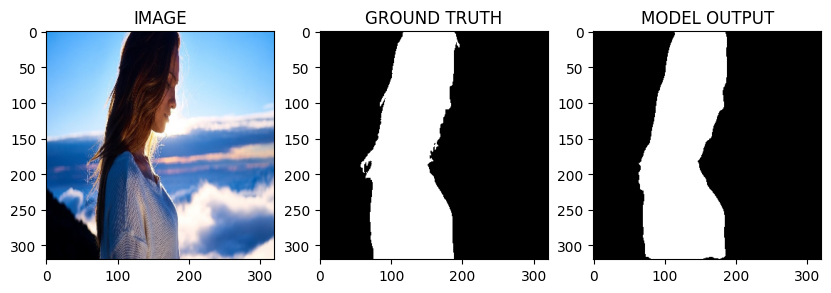

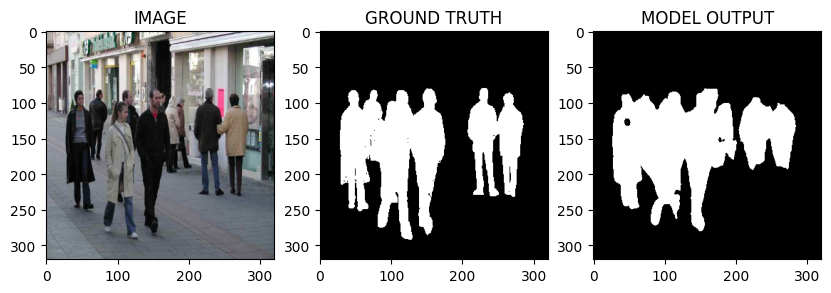

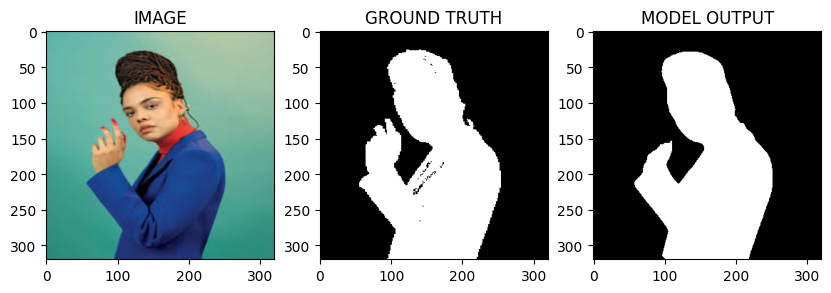

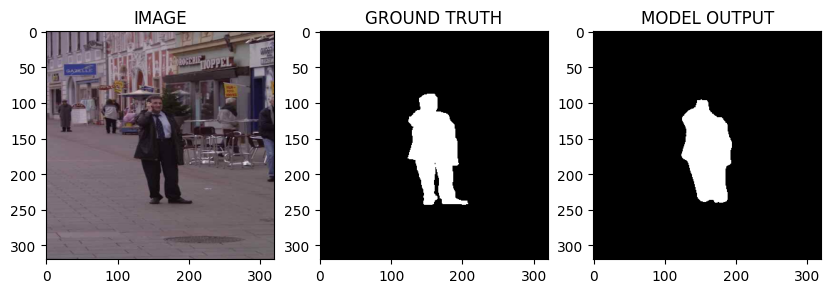

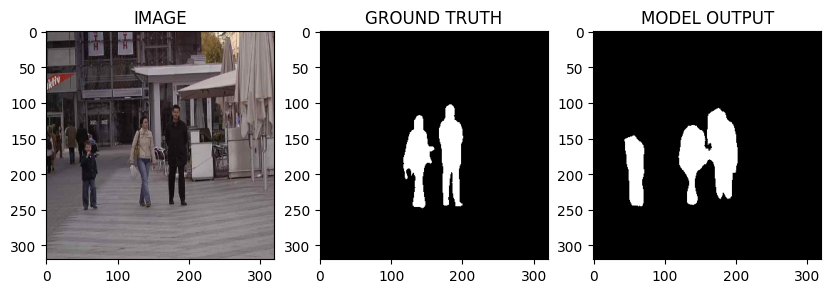

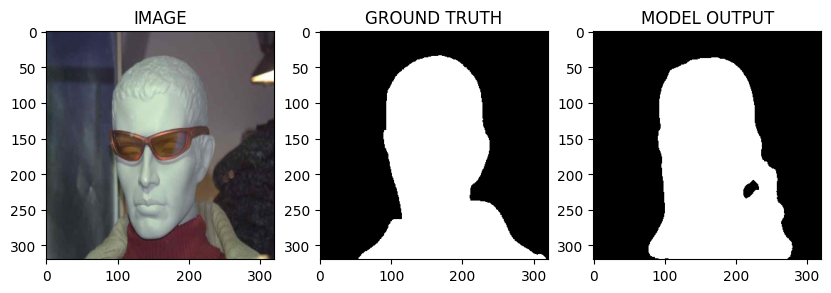

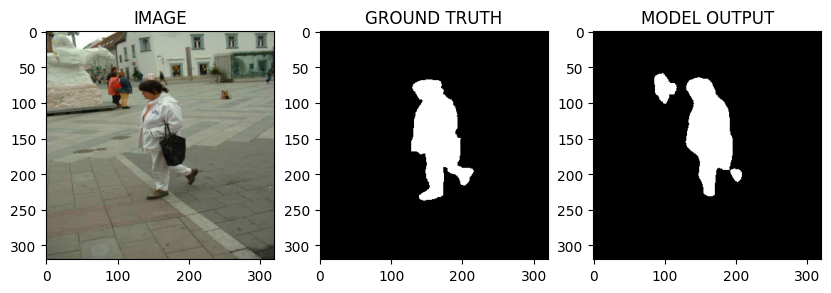

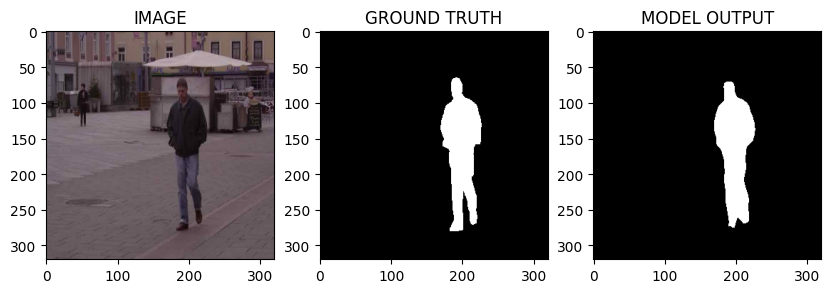

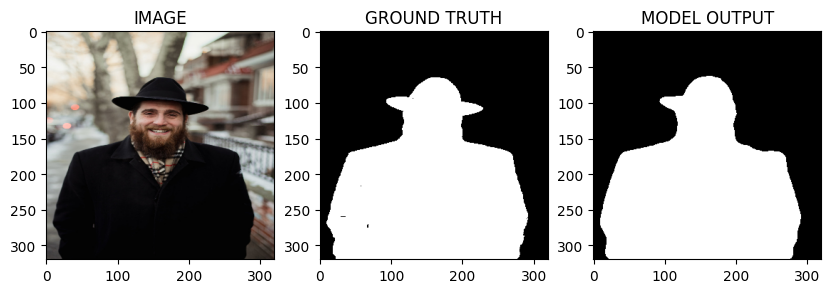

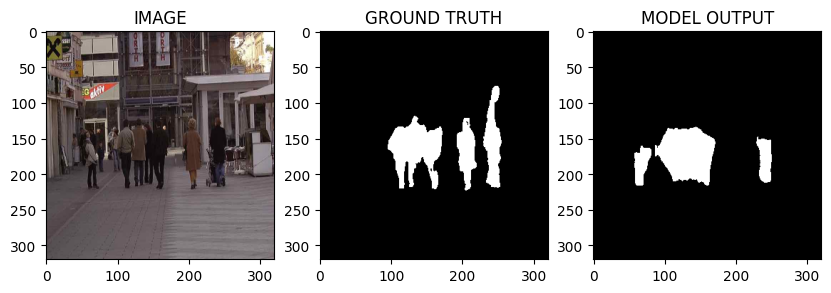

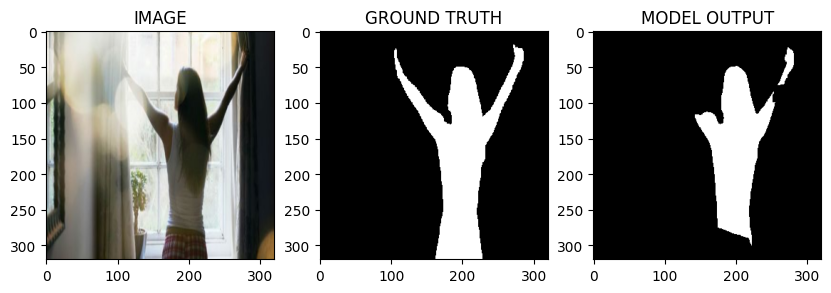

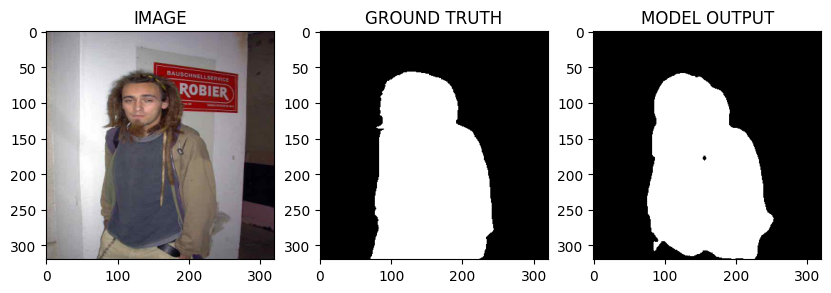

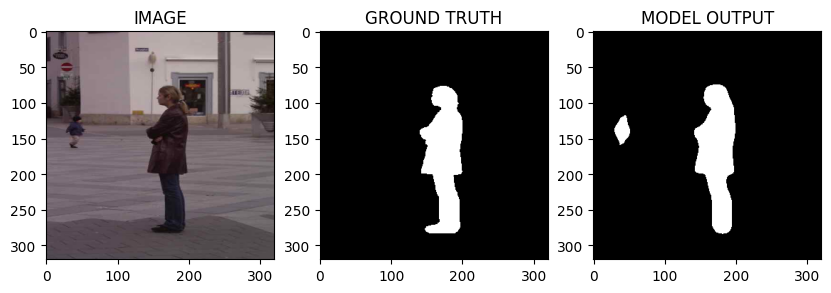

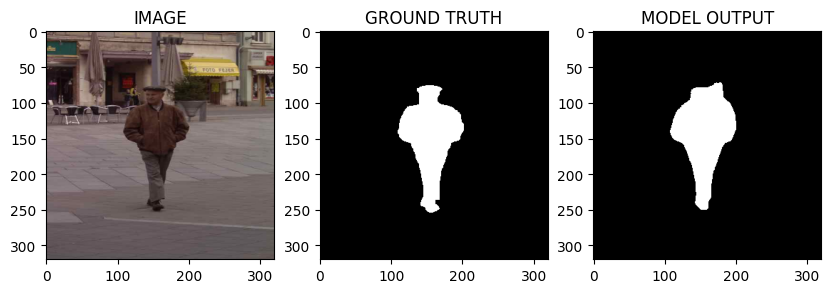

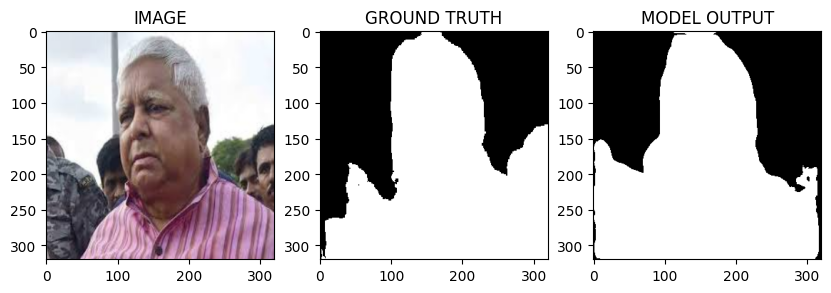

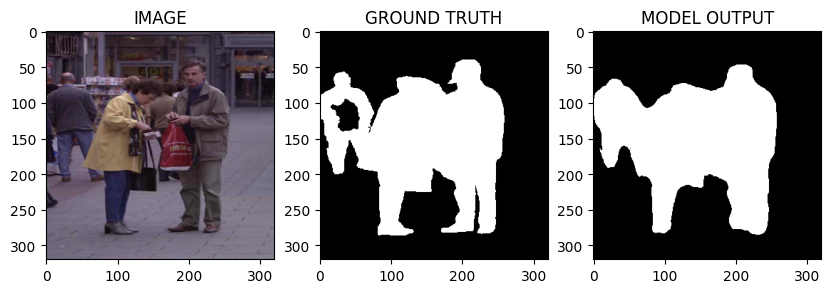

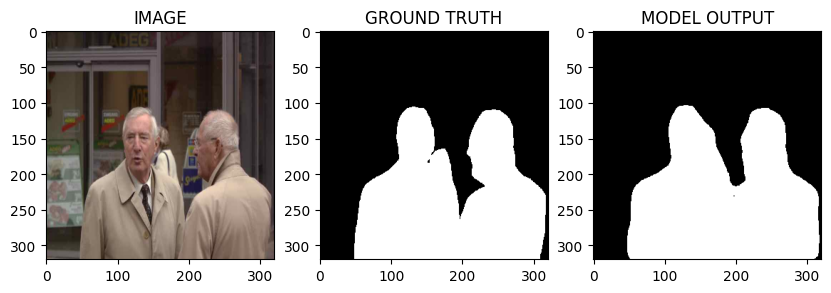

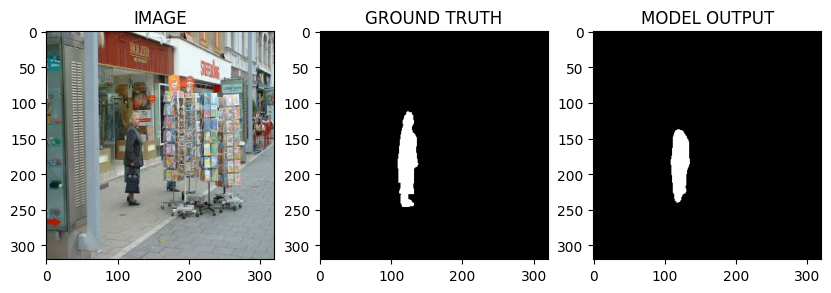

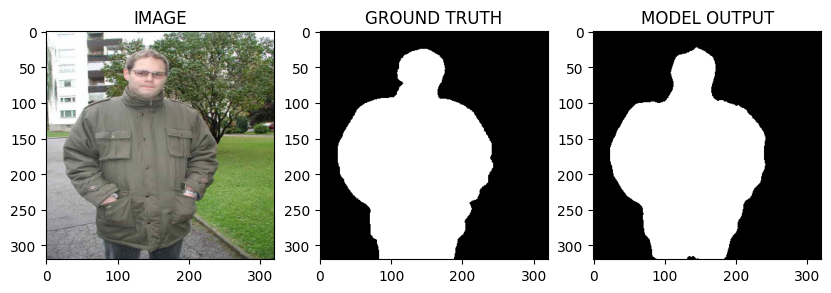

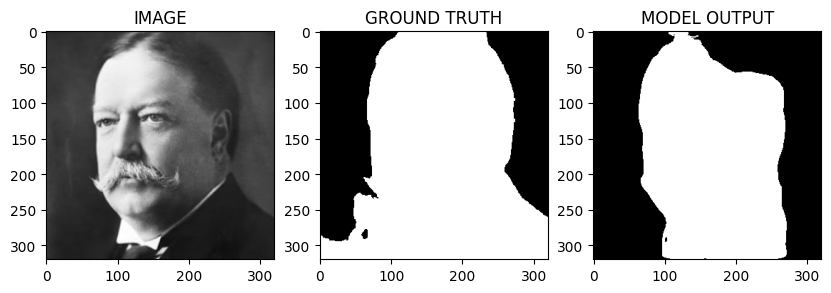

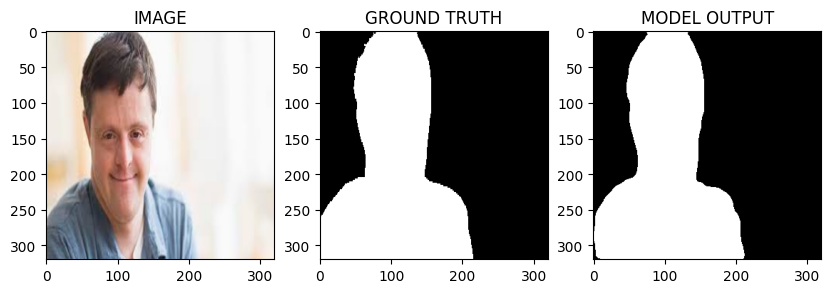

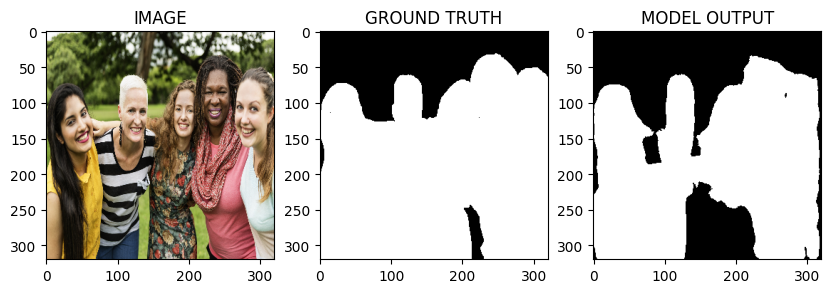

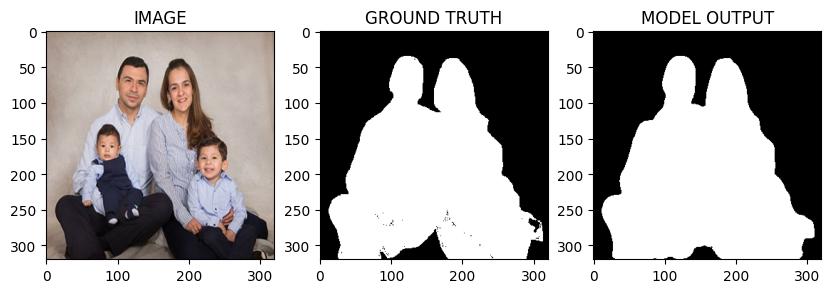

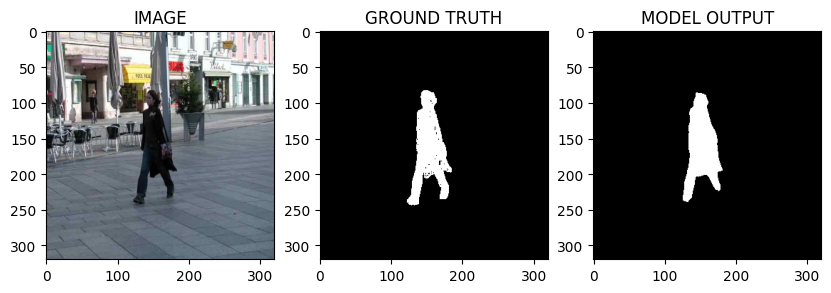

In [116]:
model.load_state_dict(torch.load('best_model.pt'))

for idx in range(len(valset)) :
# idx = 1
    with torch.no_grad():
        image,mask = valset[idx]
        logits_mask = model(image.to('cuda').unsqueeze(0))
        pred_mask = torch.sigmoid(logits_mask)
        pred_mask = (pred_mask>0.5)*1.0
        helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

(320, 320, 1)


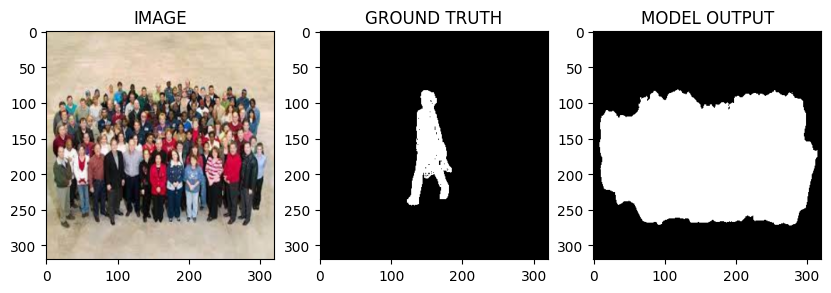

In [152]:
model.load_state_dict(torch.load('best_model.pt'))


# idx = 1
with torch.no_grad():
    image = cv2.imread(r"C:\Users\91987\Downloads\download.jpg")
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(320,320))
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    image = torch.Tensor(image)/255.0
    
    logits_mask = model(image.to('cuda').unsqueeze(0))
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask>0.5)*1.0
    helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))
    img = np.transpose(pred_mask.detach().cpu().squeeze(0),(1,2,0))
    print(img.numpy().shape)
    # img = cv2.cvtColor(img.numpy(),cv2.COLOR_RGB2GRAY)
    # plt.imshow(img)
    # plt.show()
    # print(img.shape)